In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import math
import matplotlib.pyplot as plt

In [4]:
def display_bgr2rgp(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_img)
    plt.show()
    
def preprocess(img, factor=2):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)

def cell_in_same_row(c1, c2):
    c1_center = c1[1] + c1[3] / 2
    c2_bottom = c2[1] + c2[3]
    c2_top = c2[1]
    return c2_top < c1_center < c2_bottom

def avg_height_of_center(row):
    centers = [y + h / 2 for x, y, w, h in row]
    return sum(centers) / len(centers)

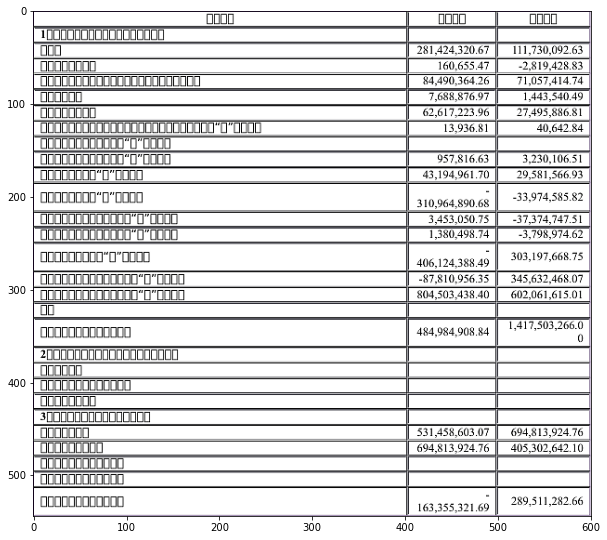

In [63]:
img_path = "images/48643.png"

img = cv.imread(img_path)
img = preprocess(img, 2)

display_bgr2rgp(img)

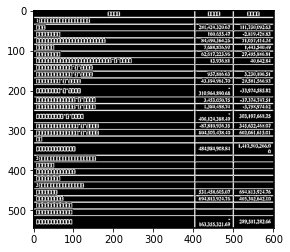

In [79]:
x = binarilize(img)
plt.imshow(x, cmap='gray')
plt.show()

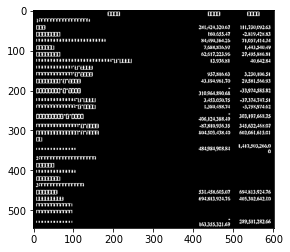

In [80]:
x = remove_border(x, REMOVE_SCALE=7)
plt.imshow(x, cmap='gray')
plt.show()

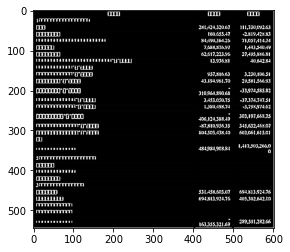

In [81]:
x = creat_new_border(x)
plt.imshow(x, cmap='gray')
plt.show()

In [77]:
def binarilize(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (3,3), 0, 0)
    thresh = cv.adaptiveThreshold(~blur,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,5,-2,)
    # remove border noise
    cv.rectangle(thresh, (0,0), thresh.shape[::-1], 0, 3)
    return thresh

def remove_border(thresh, REMOVE_SCALE=3):
    # get vertical and horizontal lines and remove them
    vertical = horizontal = thresh.copy()
    img_height, img_width = horizontal.shape
    
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / REMOVE_SCALE), 1))
    horizontally_opened = cv.morphologyEx(thresh, cv.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(img_height / REMOVE_SCALE)))
    vertically_opened = cv.morphologyEx(thresh, cv.MORPH_OPEN, vertical_kernel)
    both = horizontally_opened + vertically_opened
    both = cv.dilate(both, cv.getStructuringElement(cv.MORPH_RECT, (5,5)))
    
    borderless = thresh - both

    return borderless

def check_combine_column(a, b, MIN_COLUMN_SPACE=12):
    #x2 > x1
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    
    col_space = x2 - (x1 + w1) + 1
    if col_space < MIN_COLUMN_SPACE:
        new_rect = (x1, min(y1, y2), w2+x2-x1+1, max(y1+h1, y2+h2) - min(y1,y2)+ 1)
        return new_rect
    else:
        return False
    
def check_combine_row(a, b, MIN_ROW_SPACE=12):
    #y2 > y1
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    
    row_space = y2 - (y1 + h1) + 1
    if row_space < MIN_ROW_SPACE:
        new_rect = (min(x1,x2), y1, max(x1+w1, x2+w2) - min(x1,x2) + 1, h2+y2-y1+1)
        return new_rect
    else:
        return False
    
def reduce_col(rects):
    cursor = len(rects) - 1
    while cursor > 0:
        last = rects[cursor]
        next_last = rects[cursor-1] if rects[cursor-1] else None
        if next_last:
            check = check_combine_column(last, next_last)
            if check != False:
                rects.pop(cursor)
                rects.pop(cursor - 1)
                rects.insert(cursor-1, check)
        cursor -= 1
    return rects

def reduce_row(rects):
    cursor = len(rects) - 1
    while cursor > 0:
        last = rects[cursor]
        next_last = rects[cursor-1] if rects[cursor-1] else None
        if next_last:
            check = check_combine_row(last, next_last)
            if check != False:
                rects.pop(cursor)
                rects.pop(cursor - 1)
                rects.insert(cursor-1, check)
        cursor -= 1
    return rects

def creat_new_border(borderless, DILATE_SCALE=10, iterations=15, FIXED_PIXEL=5):
    # create new border by text dialating
    vertical = horizontal = borderless.copy()
    img_height, img_width = horizontal.shape
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / DILATE_SCALE), 1))
    hor_dilate = cv.dilate(horizontal, horizontal_kernel, iterations=iterations)
    
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,int(img_width / DILATE_SCALE)))
    ver_dilate = cv.dilate(horizontal, vertical_kernel, iterations=iterations)
    
    # create horizontal border
    hor_contours, hor_hierarchy = cv.findContours(hor_dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    hor_bounding_rects = [cv.boundingRect(c) for c in hor_contours]
    hor_bounding_rects = reduce_row(hor_bounding_rects)
    hor_border = borderless.copy()

    new_hor_bnd = []
    for b in hor_bounding_rects:
        temp = list(b)
        temp[1] = max(temp[1] - FIXED_PIXEL, 0)
        temp[3] = min(temp[3] + FIXED_PIXEL*2, img_width)
        new_hor_bnd.append(temp)

    for b in new_hor_bnd:
        cv.rectangle(hor_border, (b[0], b[1]), (b[0] + b[2], b[1]+ b[3]), 255, 2)
        
    # create vertical border
    ver_contours, ver_hierarchy = cv.findContours(ver_dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    ver_bounding_rects = [cv.boundingRect(c) for c in ver_contours]
    ver_bounding_rects = reduce_col(ver_bounding_rects)
    ver_border =  borderless.copy()
    
    new_ver_bnd = []
    for b in ver_bounding_rects:
        temp = list(b)
        temp[0] = max(temp[0] - FIXED_PIXEL, 0)
        temp[2] = min(temp[2] + FIXED_PIXEL*2, img_width)
        new_ver_bnd.append(temp)

    for b in new_ver_bnd:
        cv.rectangle(ver_border, (b[0], b[1]), (b[0] + b[2], b[1]+ b[3]), 255, 2)
    
    
    both = hor_border + ver_border
    bordered = borderless + both
    return bordered
    
## checked done    
    
def cell_detection(img, DETECT_SCALE=3, MIN_RECT_WIDTH = 10, MIN_RECT_HEIGHT = 10, MIN_CHAR_AREA = 18):
    # binarilize 
    thresh = binarilize(img)
    
    borderless = remove_border(thresh)
    bordered = creat_new_border(borderless)
    
    # detect horzonal and vertical lines
    vertical = horizontal = bordered.copy()
    img_height, img_width = horizontal.shape
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / DETECT_SCALE), 1))
    horizontally_opened = cv.morphologyEx(bordered, cv.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(img_height / DETECT_SCALE)))
    vertically_opened = cv.morphologyEx(bordered, cv.MORPH_OPEN, vertical_kernel)
    
    
    mask = horizontally_opened + vertically_opened
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    perimeter_lengths = [cv.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

    bounding_rects = [cv.boundingRect(a) for a in approx_polys]

    bounding_rects = [r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]]

    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]

    cells = [c for c in bounding_rects]
    # ordering the cells
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted([c for c in rest if cell_in_same_row(c, first)], key=lambda c: c[0])

        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [c for c in rest if not cell_in_same_row(c, first)]
        
    rows.sort(key=avg_height_of_center)
    
    new_rows = []
    for row in rows:
        new_row_cell = []
        for cell in row:
            cx, cy, cw, ch = cell
            cell_thresh = thresh[cy:cy+ch, cx:cx+cw]
                
            ver = hor = cell_thresh.copy()
            ih, iw = hor.shape
    
            hor_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(iw/3), 1))
            ver_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(ih/3)))
            hor_opened = cv.morphologyEx(hor, cv.MORPH_OPEN, hor_kernel)
            ver_opened = cv.morphologyEx(ver, cv.MORPH_OPEN, ver_kernel)
            
            both = hor_opened + ver_opened
            clean = cell_thresh - both

            kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
            opened = cv.morphologyEx(clean, cv.MORPH_OPEN, kernel)
            opened = cv.dilate(clean, kernel)
            contours, hierarchy = cv.findContours(opened, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            bounding_rects = [cv.boundingRect(c) for c in contours]
            FIXED_PX = 4
            char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
            if char_sized_bounding_rects:
                minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
                for x, y, w, h in char_sized_bounding_rects:
                    minx = min(minx, x)
                    miny = min(miny, y)
                    maxx = max(maxx, x + w)
                    maxy = max(maxy, y + h)
                x, y, w, h = minx, miny, maxx - minx, maxy - miny
                cropped = (cx+x, cy+y, min(iw, w), min(ih, h+FIXED_PX))
                new_row_cell.append(cropped)
#             else:
#                 cropped = (0,0,0,0)
        if new_row_cell != []:    
            new_rows.append(new_row_cell)
        
    return new_rows

In [64]:
result = cell_detection(img)
result

[]